# Dataset analysis (A + D)

This notebook inspects:

- official split (`train.txt` / `test.txt`)
- difficult images (`diff_image.txt`)
- abnormality lists (`number_abnormalities.csv`, `structural_abnormalities.csv`)
- basic annotation statistics (counts, label distribution, boxes/image)
- a few visual sanity checks (boxes overlay)

In [2]:
import os
import sys
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
from pathlib import Path
sys.path.insert(0, str(Path("..").resolve()))

In [3]:
from datasets import cfg
from datasets.dataset_a import DatasetA
from datasets.dataset_d import DatasetD

/home/neoph/dev/Train/.tenv312/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/neoph/dev/Train/.tenv312/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


In [4]:
def read_lines(p: Path):
    return [line.strip() for line in p.read_text().splitlines() if line.strip()]

def to_stems(lines):
    return [Path(x).stem for x in lines]

train_list = to_stems(read_lines(cfg.train_txt))
test_list = to_stems(read_lines(cfg.test_txt))
diff_list = to_stems(read_lines(cfg.diff_txt))

train_ids = set(train_list)
test_ids = set(test_list)
diff_ids = set(diff_list)

print("train.txt:", len(train_list))
print("test.txt :", len(test_list))
print("diff     :", len(diff_list))
print("train ∩ test:", len(train_ids & test_ids)) #ok at least train and test are different

df_normal = pd.read_csv(cfg.normal_csv)
df_number = pd.read_csv(cfg.number_csv)
df_struct = pd.read_csv(cfg.structural_csv)

normal_ids = set(Path(x).stem for x in df_normal["filename"].astype(str))
number_ids = set(Path(x).stem for x in df_number["filename"].astype(str))
struct_ids = set(Path(x).stem for x in df_struct["filename"].astype(str))

print("normal.csv     :", len(df_normal))
print("number_abn.csv :", len(df_number))
print("struct_abn.csv :", len(df_struct))

train.txt: 3750
test.txt : 1250
diff     : 122
train ∩ test: 0
normal.csv     : 4893
number_abn.csv : 59
struct_abn.csv : 50


In [5]:
ds_a = DatasetA(str(cfg.root_a_xml), str(cfg.root_a_img), cfg.label_map, cfg.max_size, num_channels=3, with_masks=False)
ds_d = DatasetD(str(cfg.root_d_xml), str(cfg.root_d_img), cfg.label_map, cfg.max_size, num_channels=3)

a_ids = set(ds_a.file_ids)
d_ids = set(ds_d.file_ids)

print("A images (xml):", len(ds_a))
print("D images (xml):", len(ds_d))

A images (xml): 5000
D images (xml): 2000


In [6]:
def subset_counts(name, ds_ids, split_ids):
    split = ds_ids & split_ids
    return {
        "set": name,
        "images": len(split),
        "difficult": len(split & diff_ids),
        "normal": len(split & normal_ids),
        "number_abn": len(split & number_ids),
        "struct_abn": len(split & struct_ids),
    }

counts = []
counts.append(subset_counts("A/train", a_ids, train_ids))
counts.append(subset_counts("A/test", a_ids, test_ids))
counts.append(subset_counts("D/train", d_ids, train_ids))
counts.append(subset_counts("D/test", d_ids, test_ids))

df_counts = pd.DataFrame(counts)
df_counts

,set,images,difficult,normal,number_abn,struct_abn
0,A/train,3744,0,3665,36,43
1,A/test,1250,122,1226,19,5
2,D/train,719,0,707,11,1
3,D/test,1116,93,1092,19,5


In [7]:
def split_count(name, ds_ids, train_ids, test_ids):
    return {
        "dataset": name,
        "total_in_dataset": len(ds_ids),
        "in_train": len(ds_ids & train_ids),
        "in_test": len(ds_ids & test_ids),
        "in_train_or_test": len(ds_ids & (train_ids | test_ids)),
        "in_neither": len(ds_ids - (train_ids | test_ids)),
        "train_test_overlap": len(ds_ids & train_ids & test_ids),
    }

summary = [
    split_count("A", a_ids, train_ids, test_ids),
    split_count("D", d_ids, train_ids, test_ids),
]

pd.DataFrame(summary)

,dataset,total_in_dataset,in_train,in_test,in_train_or_test,in_neither,train_test_overlap
0,A,5000,3744,1250,4994,6,0
1,D,2000,719,1116,1835,165,0


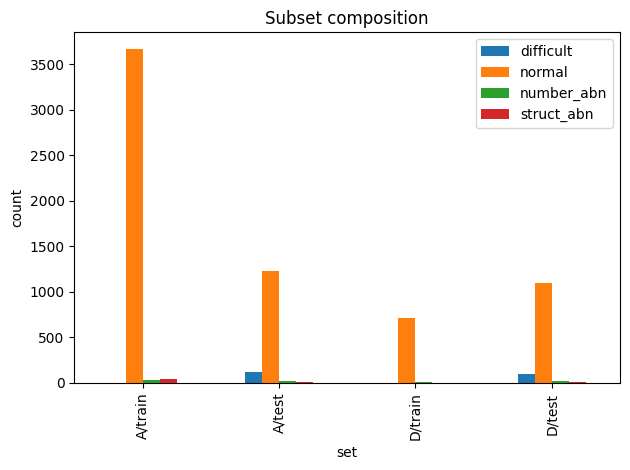

In [8]:
ax = df_counts.set_index("set")[["difficult", "normal", "number_abn", "struct_abn"]].plot(kind="bar")
ax.set_ylabel("count")
ax.set_title("Subset composition")
plt.tight_layout()
plt.show()

In [9]:
def labels_to_df(label_ctr: Counter):
    rows = [{"label": k, "count": v} for k, v in sorted(label_ctr.items())]
    return pd.DataFrame(rows)

df_a_train = labels_to_df(a_train_labels)
df_a_test = labels_to_df(a_test_labels)

NameError: name 'a_train_labels' is not defined

In [ ]:
def plot_label_dist(df, title):
    ax = df.set_index("label")["count"].plot(kind="bar")
    ax.set_title(title)
    ax.set_xlabel("label id")
    ax.set_ylabel("count")
    plt.tight_layout()
    plt.show()

plot_label_dist(df_a_train, "A/train label distribution")
plot_label_dist(df_a_test, "A/test label distribution")

In [ ]:
ax = pd.Series(a_train_n).plot(kind="hist", bins=40)
ax.set_title("A/train boxes per image")
ax.set_xlabel("boxes")
plt.tight_layout()
plt.show()

ax = pd.Series(a_test_n).plot(kind="hist", bins=40)
ax.set_title("A/test boxes per image")
ax.set_xlabel("boxes")
plt.tight_layout()
plt.show()

In [11]:
from pathlib import Path
import xml.etree.ElementTree as ET
from collections import Counter
import pandas as pd
from PIL import Image

from datasets import cfg


def size_table(xml_dir, img_dir):
    sizes = []
    for xml_path in sorted(Path(xml_dir).glob("*.xml")):
        root = ET.parse(xml_path).getroot()
        fname = root.find("filename").text.strip()
        with Image.open(Path(img_dir) / fname) as im:
            sizes.append(im.size)  # (w, h)

    c = Counter(sizes)
    df = pd.DataFrame([{"w": w, "h": h, "count": n} for (w, h), n in c.items()])
    df = df.sort_values(["count", "w", "h"], ascending=[False, True, True]).reset_index(drop=True)

    meta = {
        "n_images": len(sizes),
        "n_unique_sizes": len(c),
        "min_w": min(w for w, h in sizes),
        "max_w": max(w for w, h in sizes),
        "min_h": min(h for w, h in sizes),
        "max_h": max(h for w, h in sizes),
    }
    return meta, df


meta_a, df_a = size_table(cfg.root_a_xml, cfg.root_a_img)
meta_d, df_d = size_table(cfg.root_d_xml, cfg.root_d_img)

pd.DataFrame([{"dataset": "A", **meta_a}, {"dataset": "D", **meta_d}])


,dataset,n_images,n_unique_sizes,min_w,max_w,min_h,max_h
0,A,5000,4911,360,1360,383,1024
1,D,2000,1967,415,1360,393,1024


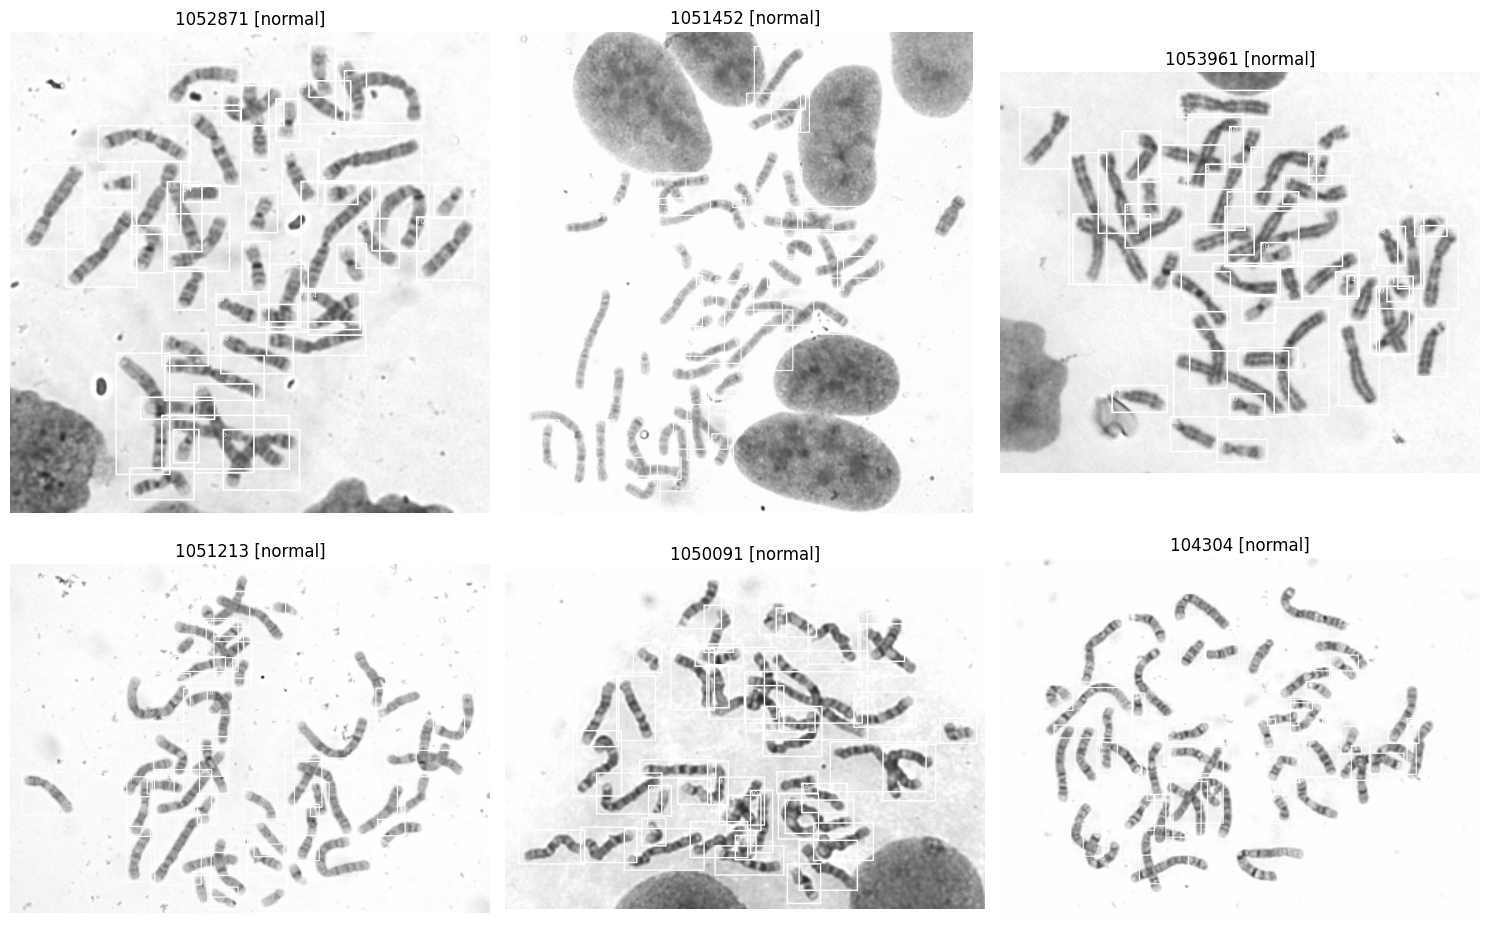

In [19]:
from PIL import Image, ImageDraw

def show_examples(ds, split_ids, n=6, seed=0):
    rng = np.random.default_rng(seed)
    idx = [i for i, fid in enumerate(ds.file_ids) if fid in split_ids]
    pick = rng.choice(idx, size=min(n, len(idx)), replace=False).tolist()
    cols = 3
    rows = int(np.ceil(len(pick) / cols))
    plt.figure(figsize=(cols * 5, rows * 5))
    for k, i in enumerate(pick, start=1):
        xml_path = ds.ann_files[i]
        root = ET.parse(xml_path).getroot()
        fname = root.find("filename").text.strip()
        img = Image.open(os.path.join(ds.img_dir, fname)).convert("RGB")
        draw = ImageDraw.Draw(img)
        labels, boxes = parse_xml_labels_boxes(xml_path, cfg.label_map)
        for (x1, y1, x2, y2), lab in zip(boxes, labels):
            draw.rectangle([x1, y1, x2, y2], width=2)
            draw.text((x1, y1), str(lab))
        fid = ds.file_ids[i]
        tags = []
        if fid in diff_ids:
            tags.append("diff")
        if fid in number_ids:
            tags.append("number")
        if fid in struct_ids:
            tags.append("struct")
        if fid in normal_ids:
            tags.append("normal")
        plt.subplot(rows, cols, k)
        plt.imshow(img)
        plt.axis("off")
        plt.title(fid + (" [" + ",".join(tags) + "]" if tags else ""))
    plt.tight_layout()
    plt.show()

show_examples(ds_a, test_ids, n=6, seed=1)

In [21]:
def intersection_report(name, ids):
    return {
        "name": name,
        "train": len(ids & train_ids),
        "test": len(ids & test_ids),
        "diff": len(ids & diff_ids),
        "train∩diff": len(ids & train_ids & diff_ids),
        "test∩diff": len(ids & test_ids & diff_ids),
    }

pd.DataFrame([
    intersection_report("normal", normal_ids),
    intersection_report("number_abn", number_ids),
    intersection_report("struct_abn", struct_ids),
])

,name,train,test,diff,train∩diff,test∩diff
0,normal,3667,1226,121,0,121
1,number_abn,38,19,1,0,1
2,struct_abn,45,5,0,0,0
